# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [2]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.


In [ ]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance



## 2. Data Load

#### 2.1. 데이터 로드

In [4]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../train.csv'
test_path  = '../test.csv'
xy_path = '../outputFinal.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
dt_xy = pd.read_csv(xy_path)

In [5]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape, 'XY data shape : ', dt_xy.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51) XY data shape :  (1128094, 6)


In [6]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [7]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [8]:
# train, test 각각 rows 
display(concat['is_test'].value_counts())
# train + test rows
print('concat',len(concat))
# X,Y 결측치 채운 데이터 rows
#  len(concat) == len(dt_xy) 같은 rows를 가지고 index변형이 없었기 때문에 2개의 데이터 프레임은 concat 가능
print('dt_xy',len(dt_xy))

0    1118822
1       9272
Name: is_test, dtype: int64

concat 1128094
dt_xy 1128094


#### train + test된 데이터에 XY 결측치를 채우기 위한 코드를 추가합니다.

In [9]:
display(concat[['시군구','번지','본번','도로명']].head(2))
display(concat[['시군구','번지','본번','도로명']].tail(2))

,시군구,번지,본번,도로명
0,서울특별시 강남구 개포동,658-1,658.0,언주로 3
1,서울특별시 강남구 개포동,658-1,658.0,언주로 3


,시군구,번지,본번,도로명
9270,서울특별시 중랑구 신내동,816,816.0,신내역로1길 85
9271,서울특별시 중랑구 신내동,816,816.0,신내역로1길 85


In [10]:
dt_xy_selected = dt_xy.drop(axis=1, columns=['시군구','번지','도로명'])
display(dt_xy_selected.head(2))
display(dt_xy_selected.tail(2))

,좌표X,좌표Y,주소
0,127.05721,37.476763,서울특별시 강남구 개포동 언주로 3
1,127.05721,37.476763,서울특별시 강남구 개포동 언주로 3


,좌표X,좌표Y,주소
1128092,127.063356,37.501358,서울특별시 중랑구 신내동 신내역로1길 85
1128093,127.063356,37.501358,서울특별시 중랑구 신내동 신내역로1길 85


In [11]:
# 컬럼에서 첫 번째 결측치 행 찾기
first_nan_index = concat['좌표X'].isna().idxmax()
display(first_nan_index)
concat['좌표X'].isna().sum()

975

876232

In [12]:
# X,Y값을 받아온 csv 파일로 만들 때 인덱스 생성을 하지 않아서 번거로운 작업이 늘었습니다.^^;
# 두 데이터 프레임의 인덱스를 동일하게 만듭니다. 
# 이렇게 하면 두 데이터 프레임을 병합하거나 다른 연산을 수행할 때 인덱스가 일치하게 됩니다.
display("2개의 데이터 프레임의 인텍스가 다릅니다.")
display(concat.index)
display(dt_xy_selected.index)
display("================================")

dt_xy_selected.index = concat.index

display("인텍스가 동일하게 변경되었습니다.")
display(concat.index)
display(dt_xy_selected.index)

'2개의 데이터 프레임의 인텍스가 다릅니다.'

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271],
           dtype='int64', length=1128094)

RangeIndex(start=0, stop=1128094, step=1)

'================================'

'인텍스가 동일하게 변경되었습니다.'

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271],
           dtype='int64', length=1128094)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271],
           dtype='int64', length=1128094)

In [13]:
#2개 데이터 프레임값 비교
display(concat[['시군구','번지','본번','도로명','좌표X','좌표Y']][975:976])
display(dt_xy_selected[975:976])

# 컬럼의 비어있는 값을 dt_xy_selected 컬럼 '좌표X','좌표Y' 값으로 채우기
concat['좌표X'] = concat['좌표X'].combine_first(dt_xy_selected['좌표X'])
concat['좌표Y'] = concat['좌표Y'].combine_first(dt_xy_selected['좌표Y'])

display(concat[['시군구','번지','본번','도로명','좌표X','좌표Y']][975:976])
display(dt_xy_selected[975:976])

,시군구,번지,본번,도로명,좌표X,좌표Y
975,서울특별시 강남구 개포동,189,189.0,삼성로 14,NaN,NaN


,좌표X,좌표Y,주소
975,127.063356,37.501358,서울특별시 강남구 개포동 삼성로 14


,시군구,번지,본번,도로명,좌표X,좌표Y
975,서울특별시 강남구 개포동,189,189.0,삼성로 14,127.063356,37.501358


,좌표X,좌표Y,주소
975,127.063356,37.501358,서울특별시 강남구 개포동 삼성로 14


In [14]:
# 결측치가 모두 채워졌는지 확인
display(concat['좌표X'].isna().sum())
display(concat['좌표Y'].isna().sum())

0

0

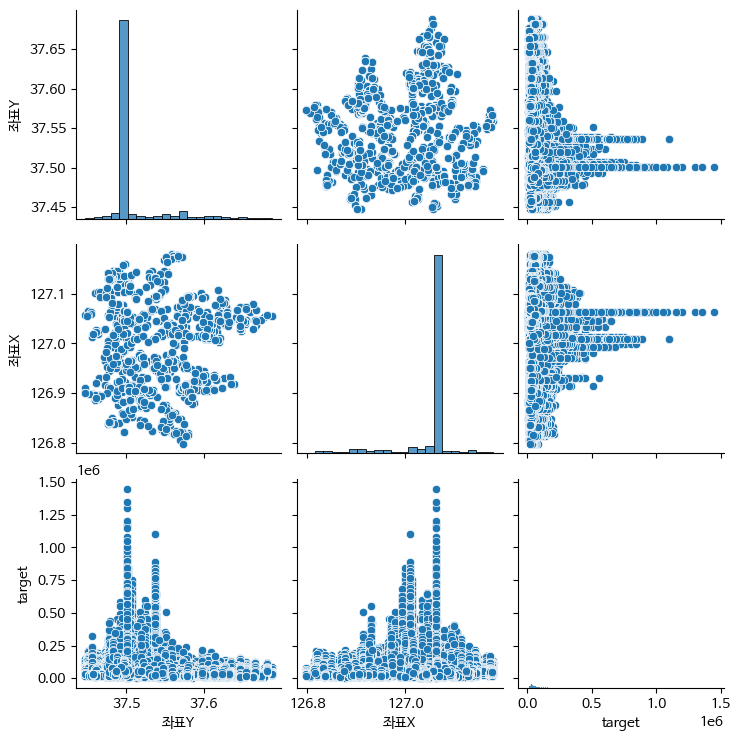

In [ ]:
# 상관관계 분석
# 위도와 경도 데이터가 집값과 어떤 상관관계를 가지는지 분석합니다.

sns.pairplot(concat[['좌표Y', '좌표X', 'target']])
plt.show()

In [15]:
# train + test + 위도 경도값 채워진 데이터 프레임 CSV 파일로 저장 
concat.to_csv('../trainTestLatLng.csv', index=True) 

## 대중교통 가중치까지 합쳐서 새로 데이터 리로드

In [16]:
# 버스, 지하철, 가중치 적용 컬럼, addBusSubway에서 합쳐서 다시 리로드한 데이터
# 여기부터 실행해도 됨 - 앞에서 작업한거 상관없이 다시 데이터 리로드
bus_subway_addPath = "../trainTestLatLngBusSubway.csv"
concat = pd.read_csv(bus_subway_addPath, index_col=0)

In [17]:
display(concat.head(1))
display(concat.index)

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,대중교통가중치
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,26.5


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271],
           dtype='int64', length=1128094)

In [18]:
display(concat.shape)
display(concat[['좌표X','좌표Y','대중교통가중치']].head(1))

(1128094, 54)

,좌표X,좌표Y,대중교통가중치
0,127.05721,37.476763,26.5


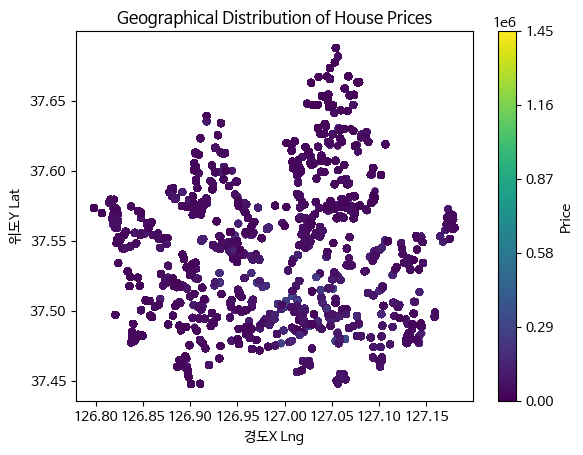

In [19]:
# 위도 경도별 아파트 시세 target값
min_price = concat['target'].min()
max_price = concat['target'].max()
ticks = np.linspace(min_price, max_price, num=6)  # Create 6 evenly spaced ticks

scatter = plt.scatter(concat['좌표X'], concat['좌표Y'], c=concat['target'], cmap='viridis', s=20)
cbar = plt.colorbar(scatter, ticks=ticks)
cbar.set_label('Price')
plt.xlabel('경도X Lng')
plt.ylabel('위도Y Lat')
plt.title('Geographical Distribution of House Prices')
plt.show()


In [20]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 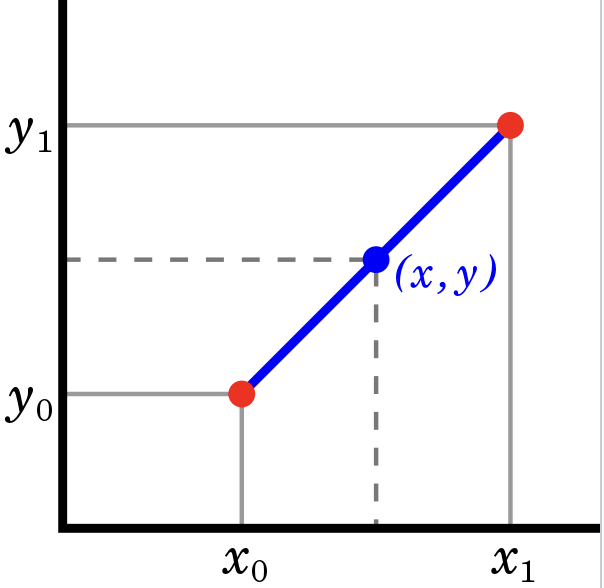

In [21]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

20230630.0    585
20230831.0    496
20230428.0    394
20230731.0    374
20230530.0    367
             ... 
20230105.0      3
20230125.0      3
20230109.0      1
20230102.0      1
20230104.0      1
Name: 등기신청일자, Length: 181, dtype: int64

In [22]:
display(concat['거래유형'].value_counts())

중개거래    38123
직거래      3520
Name: 거래유형, dtype: int64

In [23]:
display(concat['중개사소재지'].value_counts())

서울 노원구               2627
서울 송파구               2540
서울 강남구               2508
서울 강동구               2038
서울 서초구               1733
                     ... 
서울 강북구, 서울 양천구          1
경기 남양주시, 경기 성남수정구       1
서울 송파구, 인천 계양구          1
경기 연천군, 서울 송파구          1
서울 중랑구, 인천 부평구          1
Name: 중개사소재지, Length: 738, dtype: int64

In [24]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [25]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

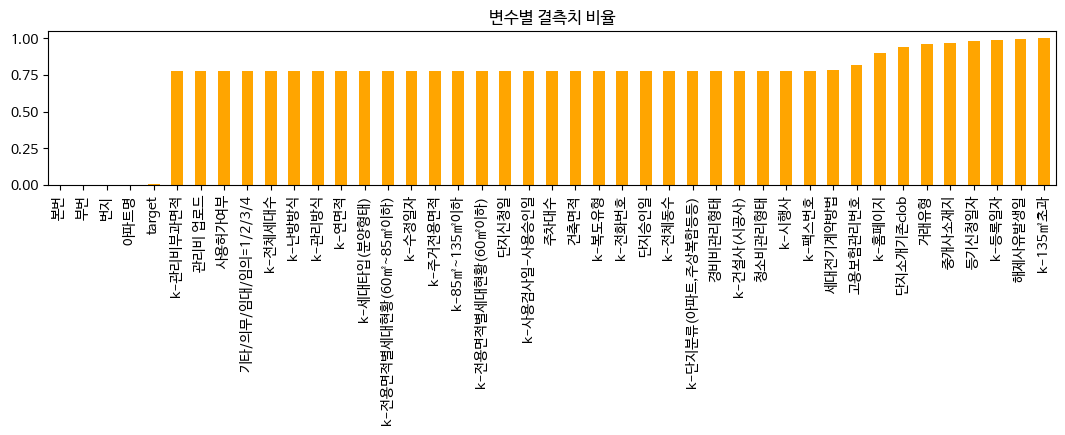

In [26]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [27]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '대중교통가중치']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [28]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [29]:
concat_select.columns.size

46

In [30]:
# 제외 변수 (feature 분석용) 
# '번지', '본번', '부번', '도로명', - 다른 데이터도 결측치가 많아서 우선 넣어놓았음
except_col = [              
              'k-전화번호', 'k-팩스번호', 'k-관리방식', 'k-복도유형', 
              'k-난방방식','k-시행사', 'k-사용검사일-사용승인일',
              'k-관리비부과면적', 'k-수정일자', 'k-건설사(시공사)',
              '고용보험관리번호',  '세대전기계약방법', '청소비관리형태',
              '단지승인일', '사용허가여부', '관리비 업로드','단지신청일',              
              'k-세대타입(분양형태)', '경비비관리형태', '기타/의무/임대/임의=1/2/3/4']

# 날짜 변수 (type 무관)
date_col = ['계약년월', '계약일', '건축년도', '해제사유발생일', '등기신청일자', 'k-사용검사일-사용승인일', 'k-등록일자', 'k-수정일자', '단지승인일', '단지신청일']

# 위의 제외 변수(except_col) 제거
concat_select.drop(columns=except_col,axis=1, inplace=True)
display(concat_select.columns,concat_select.columns.size)


Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적',
       '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '대중교통가중치'],
      dtype='object')

26

In [31]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)        877273
k-전체동수                    877207
k-전체세대수                   876125
k-연면적                     876125
k-주거전용면적                  876170
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
건축면적                      876279
주차대수                      876277
좌표X                            0
좌표Y                            0
target                      9272
is_test                        0
대중교통가중치                        0
dtype: int64

In [32]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 26 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-전체동수                  250887 non-null   float64
 13  k-전체세대수                 251969 non-null   float64
 14  k-연면적

In [33]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [34]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '대중교통가중치']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [35]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [36]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전체동수                    0
k-전체세대수                   0
k-연면적                     0
k-주거전용면적                  0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
건축면적                      0
주차대수                      0
좌표X                       0
좌표Y                       0
target                    0
is_test                   0
대중교통가중치                   0
dtype: int64

#### 아파트 브랜드별
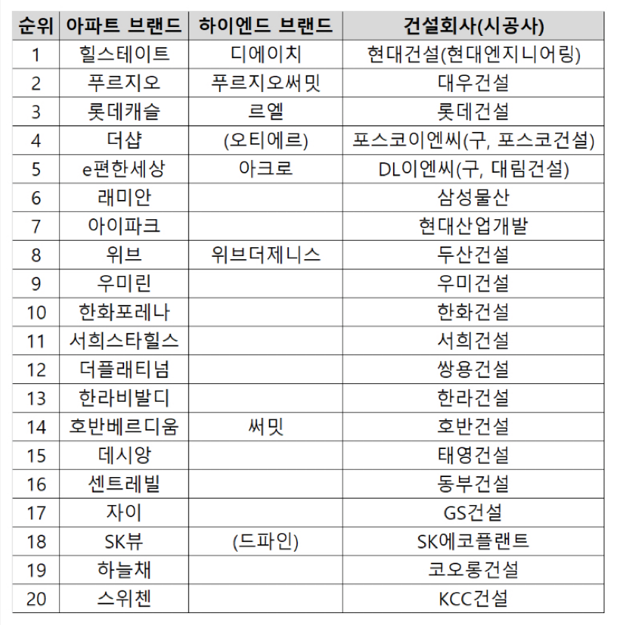


In [37]:
# 브랜드별 카테고리화
def categorize_brand(brand):
    if brand in ['디에이치', '푸르지오써밋', '르엘', '오티에르', '아크로', '위브더제니스', '써밋', '드파인']:  # 1군 브랜드 목록
        return '하이엔드'
    elif brand in ['힐스테이트', '푸르지오', '롯데캐슬','더샵', 'e편한세상','래미안','아이파크','위브']:  # 2군 브랜드 목록
        return '1군'
    elif brand in ['우미린', '한화포레나','서희스타힐스','더플래티넘','한라비발디','호반베르디움','데시앙','센트레빌','자이','SK뷰','하늘채','스위첸']:  # 하이앤드 브랜드 목록
        return '2군'
    else:
        return '기타'

concat_select['brand_category'] = concat_select['아파트명'].apply(categorize_brand)

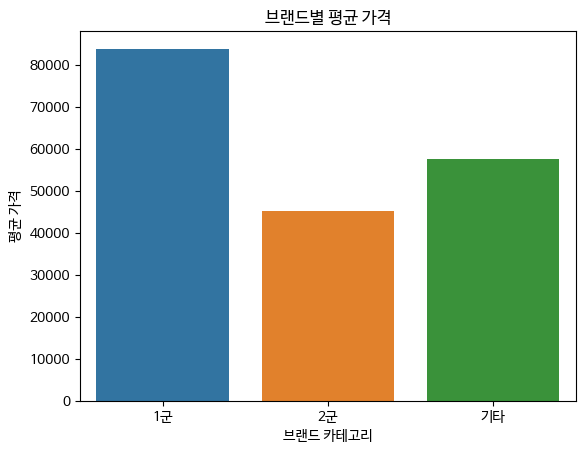

In [38]:
#브랜드별 가격 분석
import seaborn as sns
import matplotlib.pyplot as plt

# 브랜드별 평균 가격
brand_avg_price = concat_select.groupby('brand_category')['target'].mean().reset_index()

# 시각화
sns.barplot(x='brand_category', y='target', data=brand_avg_price)
plt.title('브랜드별 평균 가격')
plt.xlabel('브랜드 카테고리')
plt.ylabel('평균 가격')
plt.show()


In [39]:
#원-핫 인코딩
concat_select = pd.get_dummies(concat_select, columns=['brand_category'], drop_first=True)

In [40]:
print(concat_select.head())

             시군구     번지     본번   부번    아파트명   전용면적    계약년월  계약일  층  건축년도  ...  \
0  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201712    8  3  1987  ...   
1  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201712   22  4  1987  ...   
2  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  54.98  201712   28  5  1987  ...   
3  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201801    3  4  1987  ...   
4  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성  79.97  201801    8  2  1987  ...   

  k-85㎡~135㎡이하    건축면적   주차대수        좌표X        좌표Y    target  is_test  \
0          0.0  4858.0  262.0  127.05721  37.476763  124000.0        0   
1          0.0  4858.0  262.0  127.05721  37.476763  123500.0        0   
2          0.0  4858.0  262.0  127.05721  37.476763   91500.0        0   
3          0.0  4858.0  262.0  127.05721  37.476763  130000.0        0   
4          0.0  4858.0  262.0  127.05721  37.476763  117000.0        0   

   대중교통가중치  brand_category_2군  brand_category_기타  
0     26.5       

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

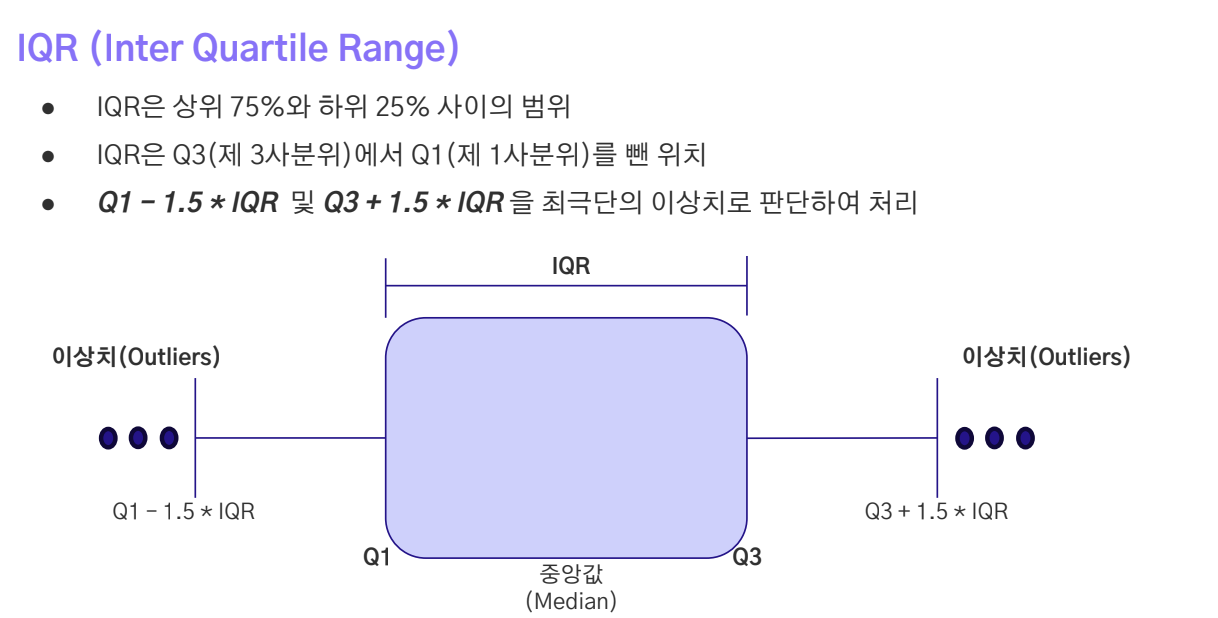

In [41]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 28)


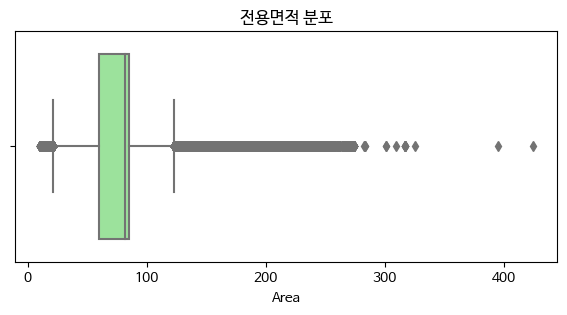

In [42]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [43]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 7.67 * IQR    # 280 미터 정도로 조정

    # display(lower_bound,upper_bound)

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [44]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [45]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1111690, 28)


In [46]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1102418
1       9272
Name: is_test, dtype: int64

### 지하층은 1값으로 대체

In [47]:
concat_select['층'] = concat_select['층'].apply(lambda x: 1 if x<0 else x)

In [48]:
concat_select[concat_select['층']<0]

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,k-85㎡~135㎡이하,건축면적,주차대수,좌표X,좌표Y,target,is_test,대중교통가중치,brand_category_2군,brand_category_기타


## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

#### 시군구 분리

In [49]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [50]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적',
       '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '대중교통가중치',
       'brand_category_2군', 'brand_category_기타', '구', '동', '계약년', '계약월'],
      dtype='object')

#### 강남여부
- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [51]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk), "값이 동일하지 않습니다."       # 알맞게 분리되었는지 체크합니다.

In [52]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [53]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적',
       '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '대중교통가중치',
       'brand_category_2군', 'brand_category_기타', '구', '동', '계약년', '계약월',
       '강남여부'],
      dtype='object')

#### 구별 평균 가격 변수 생성

In [54]:
# 구별 평균 가격 계산
gu_mean_price = concat_select.groupby('구')['target'].mean().rename('구별_평균_가격')

# 원본 데이터프레임에 구별 평균 가격 추가
concat_select = concat_select.merge(gu_mean_price, on='구')

In [55]:
# display(concat_select.head(2))
# display(concat_select.columns)

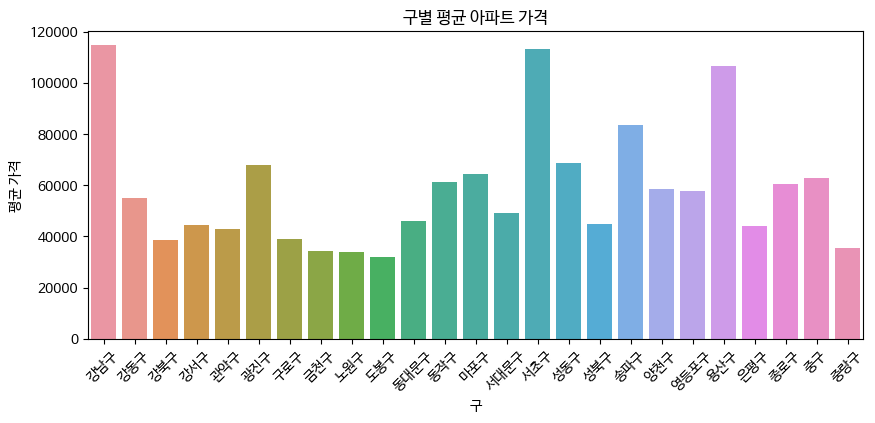

In [62]:
# 구별 평균 가격 계산
gu_avg_price = concat_select.groupby('구')['target'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 4))
sns.barplot(x='구', y='target', data=gu_avg_price)
plt.title('구별 평균 아파트 가격')
plt.xlabel('구')
plt.ylabel('평균 가격')
plt.xticks(rotation=45)
plt.show()


#### 동별가격, 표준편차

In [ ]:
# 동별 평균 가격 및 표준편차 계산
dong_stats = concat_select.groupby('동')['target'].agg(['mean']).rename(columns={'mean': '동별_평균_가격'})

# 원본 데이터프레임에 동별 평균 가격 및 표준편차 추가
concat_select = concat_select.merge(dong_stats, on='동', how='left')

In [ ]:
display(concat_select.head(2))
display(concat_select.columns)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,대중교통가중치,brand_category_2군,brand_category_기타,구,동,계약년,계약월,강남여부,구별_평균_가격,동별_평균_가격
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,...,26.5,0,1,강남구,개포동,2017,12,1,114570.779152,92107.125518
1,658-1,658.0,1.0,개포6차우성,79.97,22,4,1987,언주로 3,아파트,...,26.5,0,1,강남구,개포동,2017,12,1,114570.779152,92107.125518


Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적',
       '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '대중교통가중치',
       'brand_category_2군', 'brand_category_기타', '구', '동', '계약년', '계약월',
       '강남여부', '구별_평균_가격', '동별_평균_가격'],
      dtype='object')

#### 신축여부
- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

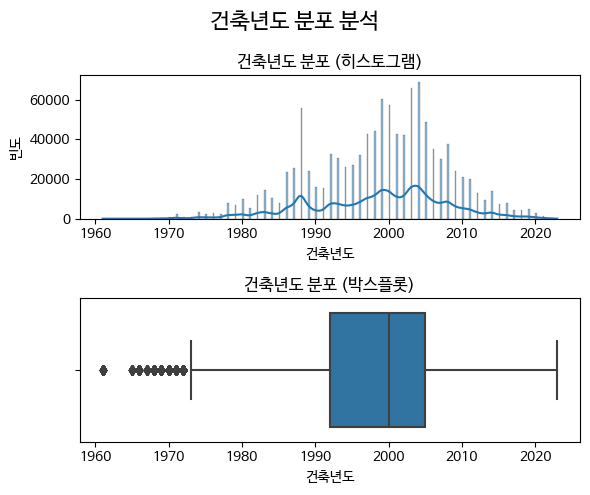

count    1.111690e+06
mean     1.998570e+03
std      9.238404e+00
min      1.961000e+03
10%      1.986000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.010000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64


In [ ]:
# 그래프 크기 설정
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))

# 히스토그램
sns.histplot(data=concat_select, x='건축년도', kde=True, ax=ax1)
ax1.set_title('건축년도 분포 (히스토그램)')
ax1.set_xlabel('건축년도')
ax1.set_ylabel('빈도')

# 박스플롯
sns.boxplot(data=concat_select, x='건축년도', ax=ax2)
ax2.set_title('건축년도 분포 (박스플롯)')
ax2.set_xlabel('건축년도')

# 전체 타이틀 설정
plt.suptitle('건축년도 분포 분석', fontsize=16)

# 그래프 간 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

# 주요 통계치 출력
print(concat_select['건축년도'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.9]))

In [ ]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2004 else 0)

In [ ]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,brand_category_2군,brand_category_기타,구,동,계약년,계약월,강남여부,구별_평균_가격,동별_평균_가격,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,...,0,1,강남구,개포동,2017,12,1,114570.779152,92107.125518,0


In [ ]:
concat_select.shape

(1111690, 34)

In [ ]:
concat_select.isna().sum()

번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전체동수                    0
k-전체세대수                   0
k-연면적                     0
k-주거전용면적                  0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
건축면적                      0
주차대수                      0
좌표X                       0
좌표Y                       0
target                    0
is_test                   0
대중교통가중치                   0
brand_category_2군         0
brand_category_기타         0
구                         0
동                         0
계약년                       0
계약월                       0
강남여부                      0
구별_평균_가격                  0
동별_평균_가격                  0
신축여부                      0
dtype: int64

#### 상관관계 분석
변수간의 상관관계 분석하여 중요한 변수들을 파악합니다.

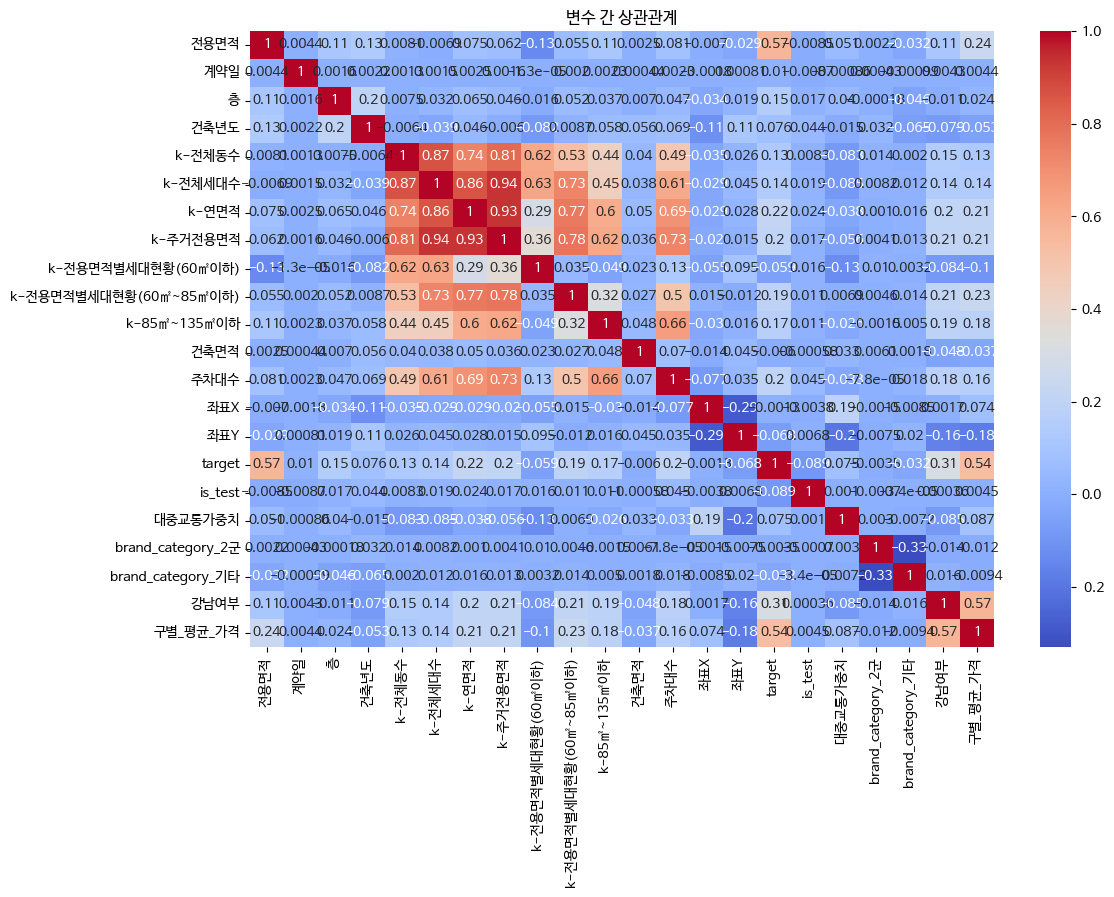

In [66]:
# 상관관계 행렬 계산
corr_matrix = concat_select.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('변수 간 상관관계')
plt.show()


- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [ ]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1102418, 33) (9272, 33)


In [ ]:
dt_test.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,brand_category_2군,brand_category_기타,구,동,계약년,계약월,강남여부,구별_평균_가격,동별_평균_가격,신축여부
68651,658-1,658.0,1.0,개포6차우성,79.97,26,5,1987,언주로 3,아파트,...,0,1,강남구,개포동,2023,07,1,114570.779152,92107.125518,0


In [ ]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

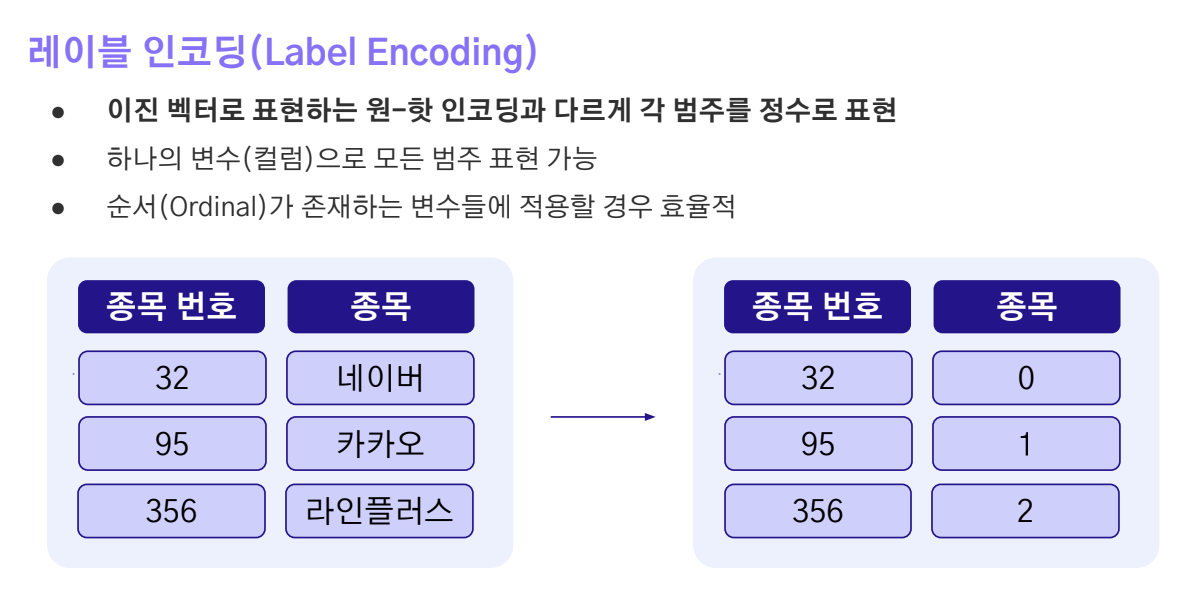

In [ ]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '대중교통가중치', 'brand_category_2군', 'brand_category_기타', '강남여부', '구별_평균_가격', '동별_평균_가격', '신축여부']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', '구', '동', '계약년', '계약월']


In [ ]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


In [ ]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,brand_category_2군,brand_category_기타,구,동,계약년,계약월,강남여부,구별_평균_가격,동별_평균_가격,신축여부
0,4630,1141,1,311,79.97,8,3,1987,6052,3,...,0,1,0,8,10,11,1,114570.779152,92107.125518,0


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [ ]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [ ]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [ ]:
'''
1.
RandomForestRegressor: 
랜덤 포레스트 알고리즘을 사용한 회귀 모델입니다.
여러 개의 결정 트리를 생성하고 그 결과를 종합하여 예측을 수행합니다.
2.
n_estimators=5: 
랜덤 포레스트에서 생성할 트리의 개수를 지정합니다.
여기서는 5개의 트리를 생성합니다.
일반적으로 이 값이 클수록 모델의 성능이 좋아지지만, 계산 시간도 증가합니다.
3.
criterion='squared_error': 
트리의 품질을 측정하는 기준을 지정합니다.
'squared_error'는 평균 제곱 오차(MSE)를 사용한다는 의미입니다.
4.
random_state=1: 
난수 생성을 위한 시드(seed) 값입니다.
이 값을 고정하면 모델 학습 시 동일한 결과를 얻을 수 있어 재현성이 보장됩니다.
5.
n_jobs=-1: 
모델 학습 시 사용할 CPU 코어의 수를 지정합니다.
'-1'은 가능한 모든 코어를 사용한다는 의미로, 학습 속도를 높일 수 있습니다.


이 코드의 목적과 의의:
RandomForest 모델을 초기화하여 회귀 문제를 해결하려고 합니다.
비교적 적은 수의 트리(5개)를 사용하고 있어, 빠른 학습과 예측이 가능할 것입니다.
하지만 트리의 수가 적어 모델의 성능이 최적화되지 않을 수 있습니다.
n_jobs=-1을 통해 병렬 처리를 활용하여 학습 속도를 높이고 있습니다.
random_state를 고정하여 실험의 재현성을 보장하고 있습니다.
'''

"\n1.\nRandomForestRegressor: \n랜덤 포레스트 알고리즘을 사용한 회귀 모델입니다.\n여러 개의 결정 트리를 생성하고 그 결과를 종합하여 예측을 수행합니다.\n2.\nn_estimators=5: \n랜덤 포레스트에서 생성할 트리의 개수를 지정합니다.\n여기서는 5개의 트리를 생성합니다.\n일반적으로 이 값이 클수록 모델의 성능이 좋아지지만, 계산 시간도 증가합니다.\n3.\ncriterion='squared_error': \n트리의 품질을 측정하는 기준을 지정합니다.\n'squared_error'는 평균 제곱 오차(MSE)를 사용한다는 의미입니다.\n4.\nrandom_state=1: \n난수 생성을 위한 시드(seed) 값입니다.\n이 값을 고정하면 모델 학습 시 동일한 결과를 얻을 수 있어 재현성이 보장됩니다.\n5.\nn_jobs=-1: \n모델 학습 시 사용할 CPU 코어의 수를 지정합니다.\n'-1'은 가능한 모든 코어를 사용한다는 의미로, 학습 속도를 높일 수 있습니다.\n\n\n이 코드의 목적과 의의:\nRandomForest 모델을 초기화하여 회귀 문제를 해결하려고 합니다.\n비교적 적은 수의 트리(5개)를 사용하고 있어, 빠른 학습과 예측이 가능할 것입니다.\n하지만 트리의 수가 적어 모델의 성능이 최적화되지 않을 수 있습니다.\nn_jobs=-1을 통해 병렬 처리를 활용하여 학습 속도를 높이고 있습니다.\nrandom_state를 고정하여 실험의 재현성을 보장하고 있습니다.\n"

In [ ]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [ ]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 7655.091659133263


- 변수 중요도도 확인해보도록 하겠습니다.

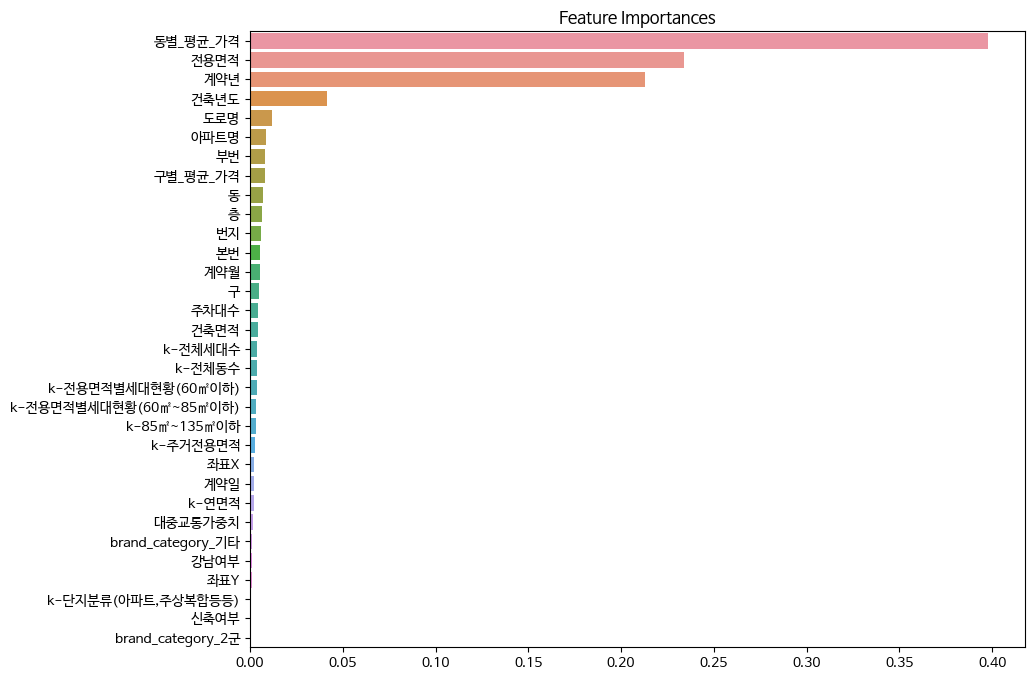

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [ ]:
'''
1.
open('saved_model.pkl', 'wb') as f:: 
'saved_model.pkl'이라는 이름의 파일을 바이너리 쓰기 모드('wb')로 엽니다.
'with' 구문을 사용하여 파일을 자동으로 닫을 수 있게 합니다.
2.
pickle.dump(model, f):
pickle 모듈의 dump 함수를 사용하여 model 객체를 파일 f에 저장합니다.
이 과정에서 모델 객체가 바이너리 형태로 직렬화되어 파일에 저장됩니다.


이 코드의 목적과 의의:
학습된 모델을 파일로 저장함으로써 나중에 다시 사용할 수 있게 합니다.
모델을 재학습하지 않고도 불러와서 예측에 사용할 수 있어 시간과 자원을 절약할 수 있습니다.
모델의 버전 관리나 배포에 유용하게 사용될 수 있습니다.

이후 이 모델을 사용하려면 pickle.load() 함수를 사용하여 파일에서 모델을 다시 불러올 수 있습니다.
'''

"\n1.\nopen('saved_model.pkl', 'wb') as f:: \n'saved_model.pkl'이라는 이름의 파일을 바이너리 쓰기 모드('wb')로 엽니다.\n'with' 구문을 사용하여 파일을 자동으로 닫을 수 있게 합니다.\n2.\npickle.dump(model, f):\npickle 모듈의 dump 함수를 사용하여 model 객체를 파일 f에 저장합니다.\n이 과정에서 모델 객체가 바이너리 형태로 직렬화되어 파일에 저장됩니다.\n\n\n이 코드의 목적과 의의:\n학습된 모델을 파일로 저장함으로써 나중에 다시 사용할 수 있게 합니다.\n모델을 재학습하지 않고도 불러와서 예측에 사용할 수 있어 시간과 자원을 절약할 수 있습니다.\n모델의 버전 관리나 배포에 유용하게 사용될 수 있습니다.\n\n이후 이 모델을 사용하려면 pickle.load() 함수를 사용하여 파일에서 모델을 다시 불러올 수 있습니다.\n"

In [ ]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [ ]:
'''
이 코드는 Permutation Importance를 사용하여 모델의 특성 중요도를 계산하는 부분입니다. 자세히 설명드리겠습니다:

perm = PermutationImportance(model,        
                             scoring = "neg_mean_squared_error",        
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)

1. `PermutationImportance`: 
   - 이는 eli5 라이브러리에서 제공하는 클래스로, 특성의 중요도를 평가하는 방법입니다.
   - 각 특성을 무작위로 섞어 모델의 성능 변화를 측정함으로써 해당 특성의 중요도를 평가합니다.

2. 주요 매개변수:
   - `model`: 앞서 학습된 모델을 사용합니다.
   - `scoring`: "neg_mean_squared_error"를 사용하여 평가 지표로 음의 평균 제곱 오차를 사용합니다. 회귀 문제에 적합한 지표입니다.
   - `random_state`: 42로 설정하여 결과의 재현성을 보장합니다.
   - `n_iter`: 3으로 설정하여 각 특성에 대해 3번의 permutation을 수행합니다.

3. `fit(X_val, y_val)`: 
   - 검증 데이터셋(X_val, y_val)을 사용하여 Permutation Importance를 계산합니다.

이 방법의 의의:
- 모델에 독립적으로 특성 중요도를 평가할 수 있습니다.
- 특성 간의 상호작용을 고려합니다.
- 비선형성을 잘 다룰 수 있습니다.

결과 해석:
- 이 분석 후, 각 특성이 모델 성능에 미치는 영향을 확인할 수 있습니다.
- 중요도가 높은 특성은 모델 예측에 큰 영향을 미치며, 낮은 특성은 상대적으로 덜 중요합니다.

이 정보를 바탕으로 모델 개선이나 특성 선택 등의 추가 작업을 수행할 수 있습니다.
'''

'\n이 코드는 Permutation Importance를 사용하여 모델의 특성 중요도를 계산하는 부분입니다. 자세히 설명드리겠습니다:\n\nperm = PermutationImportance(model,        \n                             scoring = "neg_mean_squared_error",        \n                             random_state = 42,\n                             n_iter=3).fit(X_val, y_val)\n\n1. `PermutationImportance`: \n   - 이는 eli5 라이브러리에서 제공하는 클래스로, 특성의 중요도를 평가하는 방법입니다.\n   - 각 특성을 무작위로 섞어 모델의 성능 변화를 측정함으로써 해당 특성의 중요도를 평가합니다.\n\n2. 주요 매개변수:\n   - `model`: 앞서 학습된 모델을 사용합니다.\n   - `scoring`: "neg_mean_squared_error"를 사용하여 평가 지표로 음의 평균 제곱 오차를 사용합니다. 회귀 문제에 적합한 지표입니다.\n   - `random_state`: 42로 설정하여 결과의 재현성을 보장합니다.\n   - `n_iter`: 3으로 설정하여 각 특성에 대해 3번의 permutation을 수행합니다.\n\n3. `fit(X_val, y_val)`: \n   - 검증 데이터셋(X_val, y_val)을 사용하여 Permutation Importance를 계산합니다.\n\n이 방법의 의의:\n- 모델에 독립적으로 특성 중요도를 평가할 수 있습니다.\n- 특성 간의 상호작용을 고려합니다.\n- 비선형성을 잘 다룰 수 있습니다.\n\n결과 해석:\n- 이 분석 후, 각 특성이 모델 성능에 미치는 영향을 확인할 수 있습니다.\n- 중요도가 높은 특성은 모델 예측에 큰 영향을 미치며, 낮은 특성은 상대적으로 덜 중요합니다.\n\n이 정보를 바탕으로 모

In [ ]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)

# 그래프 크기 설정
plt.figure(figsize=(12, 20))

eli5.show_weights(perm, feature_names = X_val.columns.tolist(), top = None) # valid data에 대해 적합시킵니다.

Weight,Feature
1398151738.9509 ± 5371015.8906,동별_평균_가격
1062716917.9272 ± 9448409.8935,계약년
1056571888.8693 ± 5802028.2372,전용면적
245179225.7505 ± 5826087.7118,건축년도
63181461.4389 ± 652909.8207,구별_평균_가격
62250550.7985 ± 652969.6439,도로명
39996265.2611 ± 642725.8168,부번
31890937.2783 ± 1686377.7559,동
26081296.8291 ± 352230.8905,아파트명
20814640.5747 ± 664910.9911,번지


<Figure size 1200x2000 with 0 Axes>

- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [ ]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [ ]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [ ]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [ ]:
X_val_sort.head()

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,동,계약년,계약월,강남여부,구별_평균_가격,동별_평균_가격,신축여부,target,pred,error
30639,5841,1375,0,3927,203.121,9,30,2004,6338,0,...,137,10,7,1,114570.779152,118225.744587,1,1053000.0,432500.0,3.850202e+11
1000829,4547,1121,176,115,244.950,16,11,2001,4335,0,...,285,14,3,0,106521.151038,167861.109091,0,200000.0,562382.0,1.313207e+11
682356,1086,360,148,5517,273.860,9,4,2002,3281,0,...,150,15,11,1,113240.372431,98228.496581,0,640000.0,323020.2,1.004762e+11
1001065,2360,701,222,5805,141.260,27,4,1974,2463,0,...,309,14,4,0,106521.151038,164539.512975,0,175000.0,472400.0,8.844676e+10
999535,2431,714,139,5735,167.210,15,5,1971,7175,0,...,246,16,5,0,106521.151038,110394.254170,0,585000.0,293800.0,8.479744e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [ ]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [ ]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [ ]:
display(error_top100.head(1))
display(best_top100.head(1))

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,동,계약년,계약월,강남여부,구별_평균_가격,동별_평균_가격,신축여부,target,pred,error
30639,87,87.0,0.0,아이파크,203.121,9,30,2004,영동대로 640,NULL,...,삼성동,2017,08,1,114570.779152,118225.744587,1,1053000.0,432500.0,3.850202e+11


,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,동,계약년,계약월,강남여부,구별_평균_가격,동별_평균_가격,신축여부,target,pred,error
5195,141,141.0,0.0,개포주공1단지,58.08,24,4,1982,개포로,아파트,...,개포동,2012,04,1,114570.779152,92107.125518,0,90000.0,90000.0,0.0


- 이제 분포를 비교해보도록 하겠습니다.

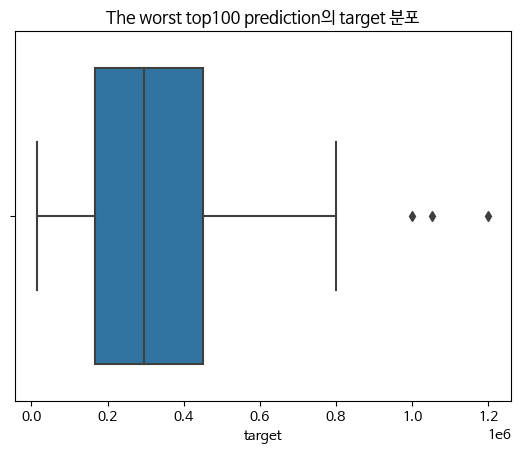

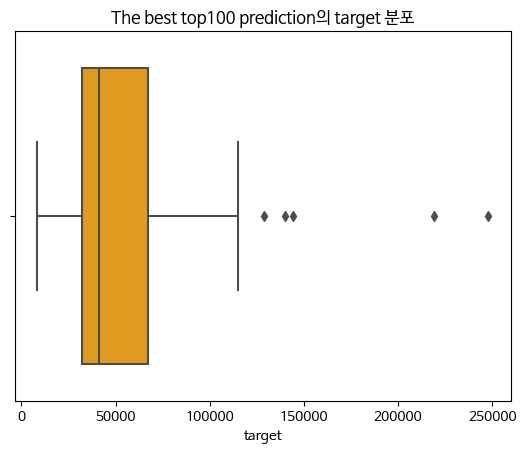

In [ ]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

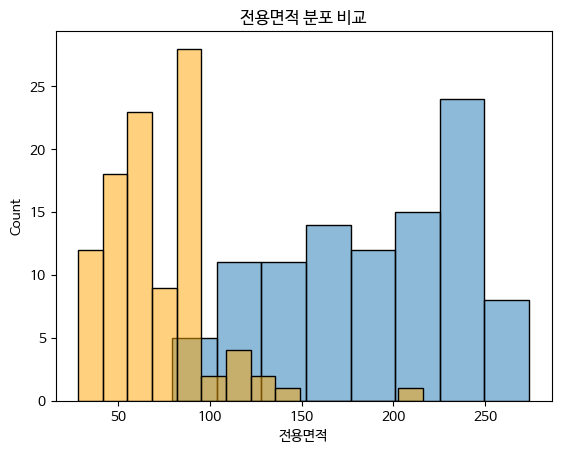

In [ ]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

## 6. Inference

In [ ]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,brand_category_2군,brand_category_기타,구,동,계약년,계약월,강남여부,구별_평균_가격,동별_평균_가격,신축여부
68651,4630,1141,1,311,79.9700,26,5,1987,6052,3,...,0,1,0,8,16,6,1,114570.779152,92107.125518,0
68652,4605,1134,1,312,108.2017,15,10,2021,459,3,...,0,1,0,8,16,7,1,114570.779152,92107.125518,1


In [ ]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 23.2 ms, sys: 362 µs, total: 23.6 ms
Wall time: 17.2 ms


In [ ]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([207600., 272200., 351200., ...,  74400.,  76700.,  73600.])

## 7. Output File Save

In [ ]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)